In [21]:
import pandas as pd
import numpy as np
import time
import random
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, RandomTreesEmbedding
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mlens.ensemble import SuperLearner
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import preprocessing
import seaborn as sns
from imblearn.pipeline import Pipeline
import shap
from sklearn.inspection import permutation_importance
from xgboost import plot_importance
import pickle
import seaborn as sns
sns.set(style="white")

# For reproducibility
np.random.seed(42)

In [22]:
X_train = np.load('X_train_PE_no_lab_measurement_UKSpain_alpha.npy')
y_train = np.load('y_train_PE_no_lab_measurement_UKSpain_alpha.npy')

In [23]:
# Load the test sets
X_test_UK = np.load('X_test_PE_no_lab_measurement_UK_alpha.npy')
y_test_UK = np.load('y_test_PE_no_lab_measurement_UK_alpha.npy')
X_test_Spain = np.load('X_test_PE_no_lab_measurement_Spain_alpha.npy')
y_test_Spain = np.load('y_test_PE_no_lab_measurement_Spain_alpha.npy')
X_test = np.load('X_test_PE_no_lab_measurement_UKSpain_alpha.npy')
y_test = np.load('y_test_PE_no_lab_measurement_UKSpain_alpha.npy')

In [24]:
# Get the validation folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

In [25]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 201407, 1: 3673}

In [43]:
unique, counts = np.unique(X_train[:, -1], return_counts=True)
dict(zip(unique, counts))

{0: 125917, 1: 79163}

In [26]:
201407/3673

54.834467737544244

# XGBoost

In [27]:
# Tune the XGBoost model using Bayesian optimisation
# Define the hyperparameters you want to sweep through (important it is manual for generalisation)
# C for regularisation if doing regression
# kernel if doing SVM for example

# In this case we are tuning for XGBoost hyperparameters
# Depth of tree
max_depth = np.linspace(1, 12, 12, endpoint=True)
max_depth = [round(x) for x in max_depth]
# maximum features
n_estimators = list(range(50, 400, 50))
# Learning rate (eta)
lr = [0.001, 0.01, 0.1, 0.3, 0.5, 0.7]
# Regularisation for imbalanced data
max_delta_step = [0, 1, 3, 5, 7, 10]
tree_method = ['hist']
# Gamma for overfitting control
min_split_loss = [0, 0.5]
# Balance weights for imbalanced classes for AUC
scale_pos_weight = [54.834]

# Create the grid
param_grid = {'max_depth': max_depth,
               'n_estimators': n_estimators,
               'learning_rate': lr,
               'max_delta_step': max_delta_step,
             'tree_method': tree_method,
             'min_split_loss': min_split_loss,
            'scale_pos_weight': scale_pos_weight}

In [28]:
# Define the model you are interested in
XGBOOSTmodel = XGBClassifier(use_label_encoder=False)

In [29]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(XGBOOSTmodel, param_grid, n_iter=50, cv=cv, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[12:54:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:54:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:54:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[12:55:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:55:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:55:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[12:55:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:55:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:55:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[12:56:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:56:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:56:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[12:56:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:57:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:57:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[12:57:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:57:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:57:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[12:58:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:58:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:58:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[12:58:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:58:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:58:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[12:59:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:59:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:59:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[12:59:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:59:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:59:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      enable_categorical=False, gamma=None,
                                      gpu_id=None, importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None, max_delta_step=None,
                                      max_depth=None, min_...
                                      use_label_encoder=False,
                                      validate_parameters=None,
                                      verbosity=None),
              refit=False, scoring='roc_auc',
              search_spaces={'learning_rate': [0.001, 0.01, 0.1, 0.3, 0.5, 0.7],
   

In [30]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('learning_rate', 0.3), ('max_delta_step', 0), ('max_depth', 2), ('min_split_loss', 0.0), ('n_estimators', 200), ('scale_pos_weight', 54.834), ('tree_method', 'hist')])
Best AUROC: 0.7562583531162164


Best parameter combo: OrderedDict([('learning_rate', 0.3), ('max_delta_step', 0), ('max_depth', 2), ('min_split_loss', 0.0), ('n_estimators', 200), ('scale_pos_weight', 54.834), ('tree_method', 'hist')])

In [31]:
# Test the model on standalone set
XGBOOSTmodel = XGBClassifier(max_depth = 2, n_estimators = 200,learning_rate = 0.3, max_delta_step = 0, min_split_loss = 0.0, scale_pos_weight = 54.834, use_label_encoder=False)

In [32]:
XGBOOSTmodel.fit(X_train, np.ravel(y_train))

[13:02:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=2, min_child_weight=1, min_split_loss=0.0, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=54.834, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [33]:
# Test results without undersampling or thresholding
print('Results for UK+Spain')
print('AUROC is:', metrics.roc_auc_score(y_test, XGBOOSTmodel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, XGBOOSTmodel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, XGBOOSTmodel.predict_proba(X_test)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test, XGBOOSTmodel.predict(X_test), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, XGBOOSTmodel.predict(X_test)))
print('#################################################')
print('Results for UK')
print('AUROC is:', metrics.roc_auc_score(y_test_UK, XGBOOSTmodel.predict_proba(X_test_UK)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_UK, XGBOOSTmodel.predict(X_test_UK)))
print('Average Precision is:', metrics.average_precision_score(y_test_UK, XGBOOSTmodel.predict_proba(X_test_UK)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_UK, XGBOOSTmodel.predict(X_test_UK), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_UK, XGBOOSTmodel.predict(X_test_UK)))
print('#################################################')
print('Results for Spain')
print('AUROC is:', metrics.roc_auc_score(y_test_Spain, XGBOOSTmodel.predict_proba(X_test_Spain)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_Spain, XGBOOSTmodel.predict(X_test_Spain)))
print('Average Precision is:', metrics.average_precision_score(y_test_Spain, XGBOOSTmodel.predict_proba(X_test_Spain)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_Spain, XGBOOSTmodel.predict(X_test_Spain), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_Spain, XGBOOSTmodel.predict(X_test_Spain)))

Results for UK+Spain
AUROC is: 0.7594872574352739
Accuracy is: 0.7225722143121843
Average Precision is: 0.05446927249201655
Weighted F1 is: 0.823107780947417
Sensitivity is: 0.6753812636165577
#################################################
Results for UK
AUROC is: 0.7445301633591079
Accuracy is: 0.7336567767618337
Average Precision is: 0.04744490602563113
Weighted F1 is: 0.8316369624454245
Sensitivity is: 0.635118306351183
#################################################
Results for Spain
AUROC is: 0.7885797101449274
Accuracy is: 0.5467105263157894
Average Precision is: 0.08849418013247802
Weighted F1 is: 0.671557599213136
Sensitivity is: 0.9565217391304348


In [35]:
# Evaluate only on specific subpopulations
y_test_men = y_test[np.where(X_test[:,1] == 1)[0]]
X_test_men = X_test[np.where(X_test[:,1] == 1)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (Men)')
print('AUROC is:', metrics.roc_auc_score(y_test_men, XGBOOSTmodel.predict_proba(X_test_men)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_men, XGBOOSTmodel.predict(X_test_men)))
print('Average Precision is:', metrics.average_precision_score(y_test_men, XGBOOSTmodel.predict_proba(X_test_men)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_men, XGBOOSTmodel.predict(X_test_men), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_men, XGBOOSTmodel.predict(X_test_men)))
print('#################################################')
y_test_women = y_test[np.where(X_test[:,1] == 0)[0]]
X_test_women = X_test[np.where(X_test[:,1] == 0)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (Women)')
print('AUROC is:', metrics.roc_auc_score(y_test_women, XGBOOSTmodel.predict_proba(X_test_women)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_women, XGBOOSTmodel.predict(X_test_women)))
print('Average Precision is:', metrics.average_precision_score(y_test_women, XGBOOSTmodel.predict_proba(X_test_women)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_women, XGBOOSTmodel.predict(X_test_women), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_women, XGBOOSTmodel.predict(X_test_women)))
print('#################################################')
y_test_20 = y_test[np.where(X_test[:,0] == 0)[0]]
X_test_20 = X_test[np.where(X_test[:,0] == 0)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (0-20)')
print('AUROC is:', metrics.roc_auc_score(y_test_20, XGBOOSTmodel.predict_proba(X_test_20)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_20, XGBOOSTmodel.predict(X_test_20)))
print('Average Precision is:', metrics.average_precision_score(y_test_20, XGBOOSTmodel.predict_proba(X_test_20)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_20, XGBOOSTmodel.predict(X_test_20), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_20, XGBOOSTmodel.predict(X_test_20)))
print('#################################################')
y_test_40 = y_test[np.where(X_test[:,0] == 1)[0]]
X_test_40 = X_test[np.where(X_test[:,0] == 1)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (20-40)')
print('AUROC is:', metrics.roc_auc_score(y_test_40, XGBOOSTmodel.predict_proba(X_test_40)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_40, XGBOOSTmodel.predict(X_test_40)))
print('Average Precision is:', metrics.average_precision_score(y_test_40, XGBOOSTmodel.predict_proba(X_test_40)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_40, XGBOOSTmodel.predict(X_test_40), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_40, XGBOOSTmodel.predict(X_test_40)))
print('#################################################')
y_test_60 = y_test[np.where(X_test[:,0] == 2)[0]]
X_test_60 = X_test[np.where(X_test[:,0] == 2)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (40-60)')
print('AUROC is:', metrics.roc_auc_score(y_test_60, XGBOOSTmodel.predict_proba(X_test_60)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_60, XGBOOSTmodel.predict(X_test_60)))
print('Average Precision is:', metrics.average_precision_score(y_test_60, XGBOOSTmodel.predict_proba(X_test_60)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_60, XGBOOSTmodel.predict(X_test_60), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_60, XGBOOSTmodel.predict(X_test_60)))
print('#################################################')
y_test_80 = y_test[np.where(X_test[:,0] == 3)[0]]
X_test_80 = X_test[np.where(X_test[:,0] == 3)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (60-80)')
print('AUROC is:', metrics.roc_auc_score(y_test_80, XGBOOSTmodel.predict_proba(X_test_80)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_80, XGBOOSTmodel.predict(X_test_80)))
print('Average Precision is:', metrics.average_precision_score(y_test_80, XGBOOSTmodel.predict_proba(X_test_80)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_80, XGBOOSTmodel.predict(X_test_80), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_80, XGBOOSTmodel.predict(X_test_80)))
print('#################################################')
y_test_120 = y_test[np.where(X_test[:,0] == 4)[0]]
X_test_120 = X_test[np.where(X_test[:,0] == 4)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (>80)')
print('AUROC is:', metrics.roc_auc_score(y_test_120, XGBOOSTmodel.predict_proba(X_test_120)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_120, XGBOOSTmodel.predict(X_test_120)))
print('Average Precision is:', metrics.average_precision_score(y_test_120, XGBOOSTmodel.predict_proba(X_test_120)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_120, XGBOOSTmodel.predict(X_test_120), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_120, XGBOOSTmodel.predict(X_test_120)))
print('#################################################')
y_test_alpha = y_test[np.where(X_test[:,-1] == 1)[0]]
X_test_alpha = X_test[np.where(X_test[:,-1] == 1)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (Alpha)')
print('AUROC is:', metrics.roc_auc_score(y_test_alpha, XGBOOSTmodel.predict_proba(X_test_alpha)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_alpha, XGBOOSTmodel.predict(X_test_alpha)))
print('Average Precision is:', metrics.average_precision_score(y_test_alpha, XGBOOSTmodel.predict_proba(X_test_alpha)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_alpha, XGBOOSTmodel.predict(X_test_alpha), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_alpha, XGBOOSTmodel.predict(X_test_alpha)))
print('#################################################')
y_test_alpha = y_test[np.where(X_test[:,-1] == 0)[0]]
X_test_alpha = X_test[np.where(X_test[:,-1] == 0)[0], :]
print('Results for UK+Spain (No Alpha)')
print('AUROC is:', metrics.roc_auc_score(y_test_alpha, XGBOOSTmodel.predict_proba(X_test_alpha)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_alpha, XGBOOSTmodel.predict(X_test_alpha)))
print('Average Precision is:', metrics.average_precision_score(y_test_alpha, XGBOOSTmodel.predict_proba(X_test_alpha)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_alpha, XGBOOSTmodel.predict(X_test_alpha), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_alpha, XGBOOSTmodel.predict(X_test_alpha)))

Results for UK+Spain (Men)
AUROC is: 0.759541106593903
Accuracy is: 0.6800344049026986
Average Precision is: 0.06175896531956312
Weighted F1 is: 0.7905130267454552
Sensitivity is: 0.73
#################################################
Results for UK+Spain (Women)
AUROC is: 0.7428928089059879
Accuracy is: 0.7733652858610065
Average Precision is: 0.04009874252738092
Weighted F1 is: 0.8600896252063699
Sensitivity is: 0.5723270440251572
#################################################
Results for UK+Spain (0-20)
AUROC is: 0.7820419985517741
Accuracy is: 0.9956678700361011
Average Precision is: 0.37890545180638413
Weighted F1 is: 0.996099513420185
Sensitivity is: 0.5
#################################################
Results for UK+Spain (20-40)
AUROC is: 0.7818706931495744
Accuracy is: 0.7411530815109344
Average Precision is: 0.05791288810523944
Weighted F1 is: 0.8346130591835456
Sensitivity is: 0.6875
#################################################
Results for UK+Spain (40-60)
AUROC is:

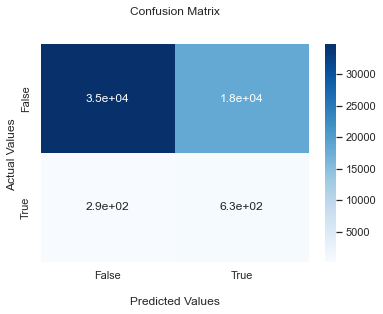

In [45]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, XGBOOSTmodel.predict(X_test)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

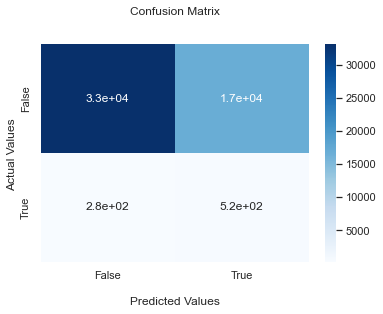

In [46]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_UK, XGBOOSTmodel.predict(X_test_UK)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

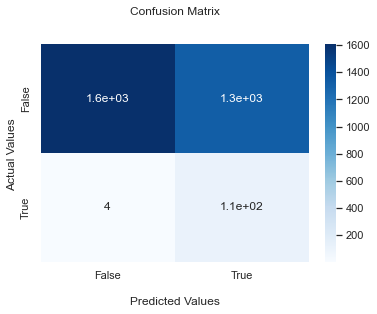

In [47]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_Spain, XGBOOSTmodel.predict(X_test_Spain)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [36]:
# Feature importance (UK/Spain)
explainer = shap.TreeExplainer(XGBOOSTmodel)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


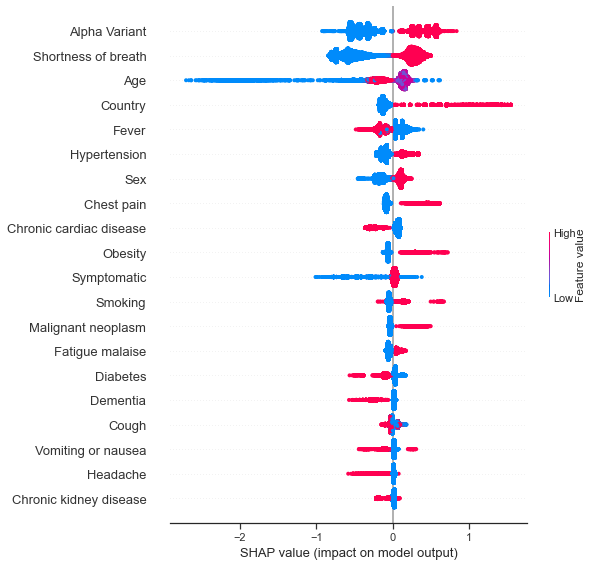

In [38]:
features = ['Age', 'Sex', 'Country', 'AIDS', 'Asthma',
       'Chronic cardiac disease',
       'Chronic haematological disease',
       'Chronic kidney disease',
       'Chronic neurological disorder',
       'Chronic pulmonary disease', 'Dementia',
       'Diabetes', 'Hypertension', 'Liver disease',
       'Malignant neoplasm', 'Malnutrition',
       'Obesity', 'Rheumatologic disorder',
       'Smoking', 'Symptomatic',
       'Abdominal pain', 'Confusion',
       'Bleeding', 'Chest pain', 'Conjunctivitis',
       'Cough', 'Diarrhoea', 'Ear pain',
       'Fatigue malaise', 'Headache',
       'Fever', 'Lost or altered sense of smell',
       'Lost or altered sense of taste', 'Lymphadenopathy',
       'Muscle aches or joint pain', 'Runny nose',
       'Seizures', 'Severe dehydration',
       'Shortness of breath', 'Skin rash',
       'Sore throat', 'Vomiting or nausea', 'Wheezing', 'Alpha Variant']
f = plt.figure()
shap.summary_plot(shap_values, X_test, feature_names=features, max_display=20)
f.savefig("PE_Shap_alpha.png", bbox_inches='tight', dpi=600)

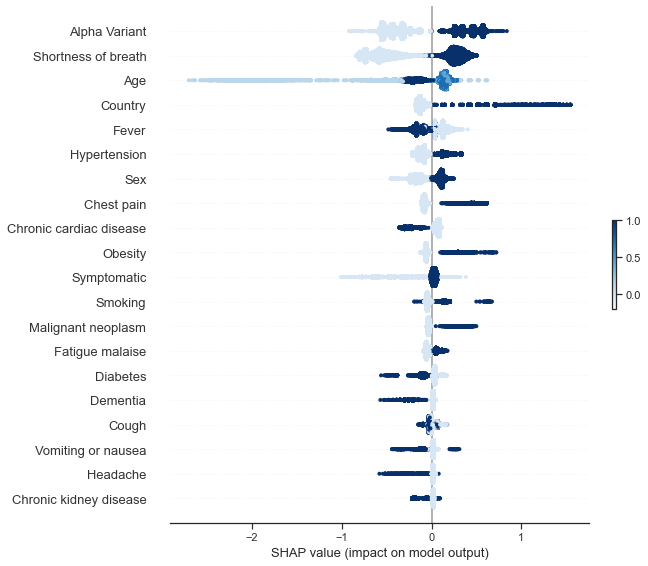

In [39]:
features = ['Age', 'Sex', 'Country', 'AIDS', 'Asthma',
       'Chronic cardiac disease',
       'Chronic haematological disease',
       'Chronic kidney disease',
       'Chronic neurological disorder',
       'Chronic pulmonary disease', 'Dementia',
       'Diabetes', 'Hypertension', 'Liver disease',
       'Malignant neoplasm', 'Malnutrition',
       'Obesity', 'Rheumatologic disorder',
       'Smoking', 'Symptomatic',
       'Abdominal pain', 'Confusion',
       'Bleeding', 'Chest pain', 'Conjunctivitis',
       'Cough', 'Diarrhoea', 'Ear pain',
       'Fatigue malaise', 'Headache',
       'Fever', 'Lost or altered sense of smell',
       'Lost or altered sense of taste', 'Lymphadenopathy',
       'Muscle aches or joint pain', 'Runny nose',
       'Seizures', 'Severe dehydration',
       'Shortness of breath', 'Skin rash',
       'Sore throat', 'Vomiting or nausea', 'Wheezing', 'Alpha Variant']

# Define colormap
my_cmap = plt.get_cmap('Blues')

f = plt.figure()
shap.summary_plot(shap_values, X_test, feature_names=features, show=False, color_bar=False)

# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_cmap)
            fcc.set_clim(vmin=-0.2)
plt.colorbar(fraction=0.01)
            
f.savefig("PE_Shap_alpha.png", bbox_inches='tight', dpi=600)

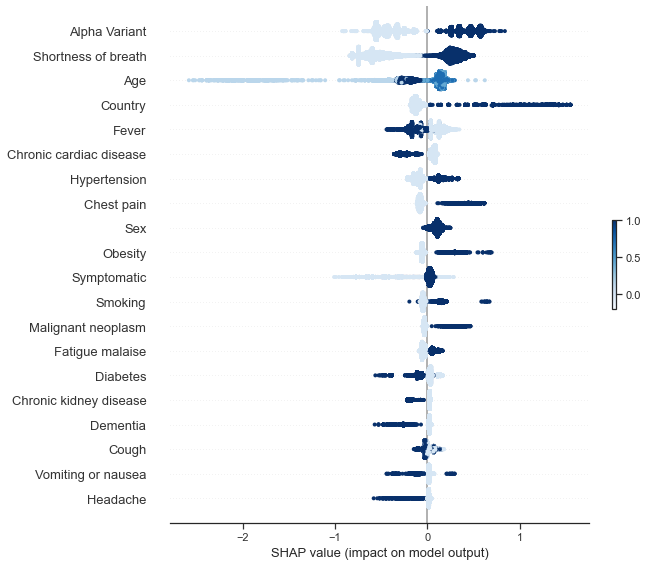

In [40]:
# Feature importance (UK/Spain) for Men
explainer = shap.TreeExplainer(XGBOOSTmodel)
shap_values = explainer.shap_values(X_test_men)

features = ['Age', 'Sex', 'Country', 'AIDS', 'Asthma',
       'Chronic cardiac disease',
       'Chronic haematological disease',
       'Chronic kidney disease',
       'Chronic neurological disorder',
       'Chronic pulmonary disease', 'Dementia',
       'Diabetes', 'Hypertension', 'Liver disease',
       'Malignant neoplasm', 'Malnutrition',
       'Obesity', 'Rheumatologic disorder',
       'Smoking', 'Symptomatic',
       'Abdominal pain', 'Confusion',
       'Bleeding', 'Chest pain', 'Conjunctivitis',
       'Cough', 'Diarrhoea', 'Ear pain',
       'Fatigue malaise', 'Headache',
       'Fever', 'Lost or altered sense of smell',
       'Lost or altered sense of taste', 'Lymphadenopathy',
       'Muscle aches or joint pain', 'Runny nose',
       'Seizures', 'Severe dehydration',
       'Shortness of breath', 'Skin rash',
       'Sore throat', 'Vomiting or nausea', 'Wheezing', 'Alpha Variant']

# Define colormap
my_cmap = plt.get_cmap('Blues')

f = plt.figure()
shap.summary_plot(shap_values, X_test_men, feature_names=features, show=False, color_bar=False)

# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_cmap)
            fcc.set_clim(vmin=-0.2)
plt.colorbar(fraction=0.01)
            
f.savefig("PE_Shap_Men_alpha.png", bbox_inches='tight', dpi=600)

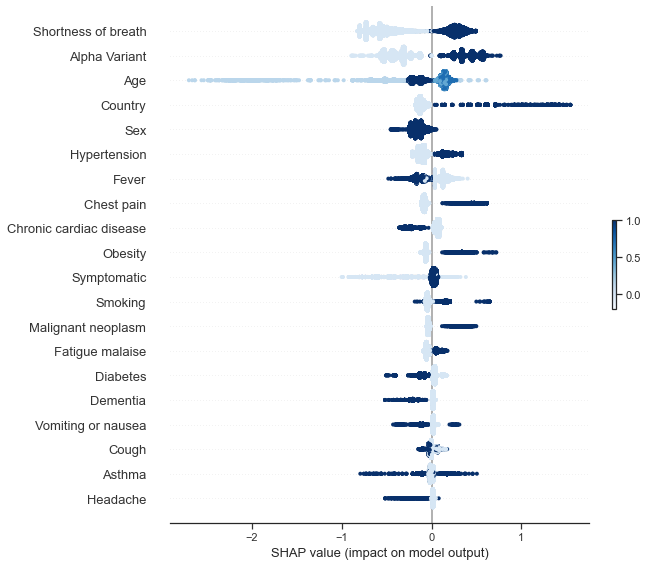

In [41]:
# Feature importance (UK/Spain) for Women
explainer = shap.TreeExplainer(XGBOOSTmodel)
shap_values = explainer.shap_values(X_test_women)

features = ['Age', 'Sex', 'Country', 'AIDS', 'Asthma',
       'Chronic cardiac disease',
       'Chronic haematological disease',
       'Chronic kidney disease',
       'Chronic neurological disorder',
       'Chronic pulmonary disease', 'Dementia',
       'Diabetes', 'Hypertension', 'Liver disease',
       'Malignant neoplasm', 'Malnutrition',
       'Obesity', 'Rheumatologic disorder',
       'Smoking', 'Symptomatic',
       'Abdominal pain', 'Confusion',
       'Bleeding', 'Chest pain', 'Conjunctivitis',
       'Cough', 'Diarrhoea', 'Ear pain',
       'Fatigue malaise', 'Headache',
       'Fever', 'Lost or altered sense of smell',
       'Lost or altered sense of taste', 'Lymphadenopathy',
       'Muscle aches or joint pain', 'Runny nose',
       'Seizures', 'Severe dehydration',
       'Shortness of breath', 'Skin rash',
       'Sore throat', 'Vomiting or nausea', 'Wheezing', 'Alpha Variant']

# Define colormap
my_cmap = plt.get_cmap('Blues')

f = plt.figure()
shap.summary_plot(shap_values, X_test_women, feature_names=features, show=False, color_bar=False)

# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_cmap)
            fcc.set_clim(vmin=-0.2)
plt.colorbar(fraction=0.01)
            
f.savefig("PE_Shap_Women_alpha.png", bbox_inches='tight', dpi=600)

<Figure size 432x288 with 0 Axes>

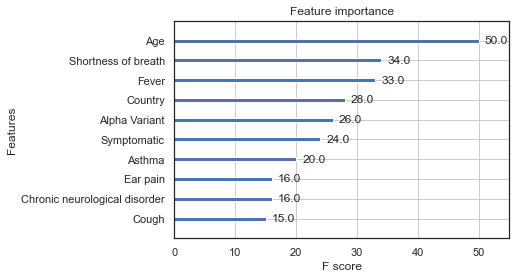

In [42]:
XGBOOSTmodel.get_booster().feature_names = features
f = plt.figure()
plot_importance(XGBOOSTmodel.get_booster(), max_num_features=10)
plt.savefig('PE_FI.png', dpi=600, bbox_inches='tight')